In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets
from sklearn import preprocessing
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
import matplotlib

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Data from http://www.footballdb.com/ & http://www.spotrac.com/nfl

**Player:** Player name

**Team:** Player Team

**Gms:** Games Played

**Rec:** Number of receptions

**Yds:** Yards

**Avg:** Receiving Average

**YPG:** Yards Per Game

**Lg:** Longest reception

**TD:** Number of TDs

**FD:** First Down Receptions

**Tar:** Number of Targets

**YAC:** Yards after Catch

In [2]:
f = '~/Desktop/NFL/NFL_WR_2016.csv'
nfl_wr = pd.read_csv(f)

In [3]:
nfl_wr.head()

,Player,Team,Gms,Rec,Yds,Avg,YPG,Lg,TD,FD,Tar,YAC
0,Larry Fitzgerald,Ari,16,107,1023,9.56,63.9,32,6,59,150,358
1,Antonio Brown,Pit,15,106,1284,12.11,85.6,51,12,64,154,437
2,Odell Beckham Jr.,NYG,16,101,1367,13.53,85.4,75t,10,65,169,534
3,Julian Edelman,NE,16,98,1106,11.29,69.1,77t,3,55,159,494
4,Jordy Nelson,GB,16,97,1257,12.96,78.6,60,14,62,152,361


In [4]:
# Clean columns
nfl_wr.columns = [x.strip().lower() for x in nfl_wr.columns]

# Inspect NaN values
nfl_wr[nfl_wr.player.isnull()]

,player,team,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac
471,NaN,SF,0,0,0,0.0,0.0,0,0,0,0,75


In [5]:
# Dropping row with NaN player
nfl_wr.dropna(axis=0, inplace=True)

nfl_wr[nfl_wr.player.isnull()]

,player,team,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac


In [6]:
# No more Null values
nfl_wr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 498
Data columns (total 12 columns):
player    498 non-null object
team      498 non-null object
gms       498 non-null int64
rec       498 non-null int64
yds       498 non-null int64
avg       498 non-null float64
ypg       498 non-null float64
lg        498 non-null object
td        498 non-null int64
fd        498 non-null int64
tar       498 non-null int64
yac       498 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 50.6+ KB


* lg = Longest catch is object...need to clean column
* Some of the ints have t's at the end
* Assuming it stands for result = TD

In [7]:
nfl_wr.lg.unique()

array(['32', '51', '75t', '77t', '60', '45t', '59', '71', '46', '67',
       '63t', '55t', '56', '30', '80t', '44', '64t', '58', '78t', '64',
       '70t', '98t', '54', '47', '66t', '42', '49', '95t', '52t', '35',
       '71t', '51t', '66', '35t', '33', '50t', '54t', '32t', '33t', '86t',
       '50', '61', '24', '41', '22', '43t', '57t', '69t', '40t', '38',
       '56t', '43', '42t', '73t', '26t', '88t', '23', '27', '39', '34',
       '17', '45', '53', '52', '74t', '36', '34t', '65t', '25', '30t',
       '48', '41t', '79t', '40', '26', '23t', '76t', '31t', '46t', '53t',
       '31', '83t', '16', '29', '48t', '84t', '28', '62', '15', '19t',
       '19', '13', '36t', '72t', '11', '14', '37', '20', '18', '12', '25t',
       '15t', '12t', '37t', '21', '20t', '9', '18t', '47t', '10', '6', '7',
       '8', '9t', '0', '3', '5', '57', '-16', '-6', '-2', '1t', '2t', '2',
       '4', '10t', '13t', '17t', '-5'], dtype=object)

In [8]:
nfl_wr.lg = nfl_wr.lg.apply(lambda x: int(x.replace('t', '')))

In [9]:
nfl_wr.describe()

,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,11.738956,23.144578,262.779116,9.850582,20.098996,28.929719,1.578313,12.767068,36.146586,116.443775
std,4.661168,25.181178,316.944116,5.452187,21.095915,20.988573,2.256868,15.590134,39.444898,132.245435
min,1.000000,0.000000,-16.000000,-16.000000,-2.700000,-16.000000,0.000000,0.000000,0.000000,-8.000000
25%,8.250000,3.000000,29.000000,6.932500,3.300000,13.000000,0.000000,1.000000,5.000000,14.250000
50%,14.000000,13.000000,126.000000,9.875000,12.000000,25.000000,1.000000,6.000000,20.000000,62.000000
75%,16.000000,36.000000,391.000000,13.000000,31.800000,42.750000,2.000000,19.000000,57.000000,187.750000
max,16.000000,107.000000,1448.000000,37.500000,100.600000,98.000000,14.000000,80.000000,173.000000,665.000000


In [10]:
nfl_wr.head()

,player,team,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac
0,Larry Fitzgerald,Ari,16,107,1023,9.56,63.9,32,6,59,150,358
1,Antonio Brown,Pit,15,106,1284,12.11,85.6,51,12,64,154,437
2,Odell Beckham Jr.,NYG,16,101,1367,13.53,85.4,75,10,65,169,534
3,Julian Edelman,NE,16,98,1106,11.29,69.1,77,3,55,159,494
4,Jordy Nelson,GB,16,97,1257,12.96,78.6,60,14,62,152,361


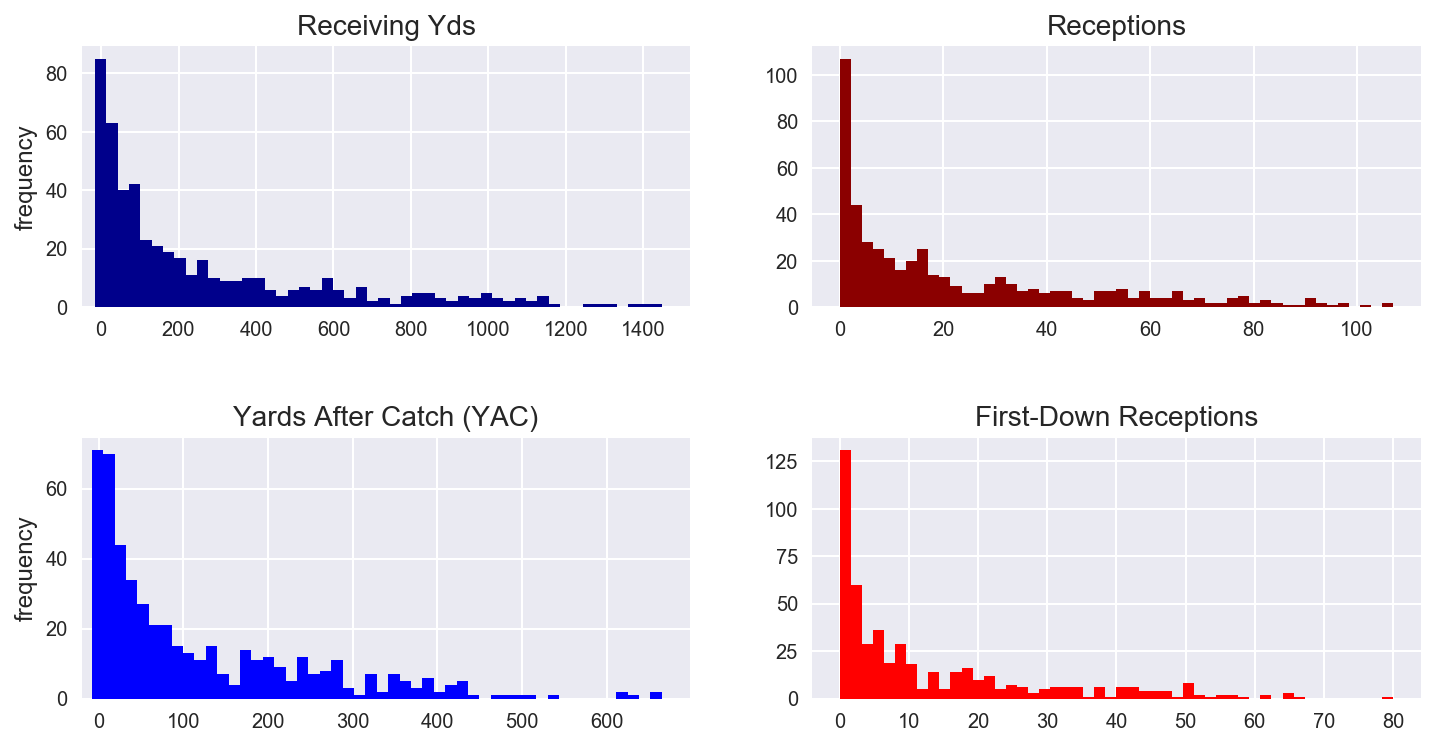

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12, 6))

ax[0, 0].hist(nfl_wr.yds, bins=50, color='darkblue')
ax[0, 0].set_title('Receiving Yds', fontsize=14)
ax[0, 0].set_xlim(-50)
ax[0, 0].set_ylabel('frequency', fontsize=12)

ax[0, 1].hist(nfl_wr.rec, bins=50, color='darkred')
ax[0, 1].set_title('Receptions', fontsize=14)

fig.subplots_adjust(hspace=.5)

ax[1, 0].hist(nfl_wr.yac, bins=50, color='blue')
ax[1, 0].set_title('Yards After Catch (YAC)', fontsize=14)
ax[1, 0].set_xlim(-20)
ax[1, 0].set_ylabel('frequency', fontsize=12)

ax[1, 1].hist(nfl_wr.fd, bins=50, color='red')
ax[1, 1].set_title('First-Down Receptions', fontsize=14)

plt.show()

In [12]:
# Aggregating Receiving Yards by Team
team_yds = nfl_wr.groupby(by='team')['yds'].sum()
team_yds = team_yds.sort_values(ascending=True).reset_index()

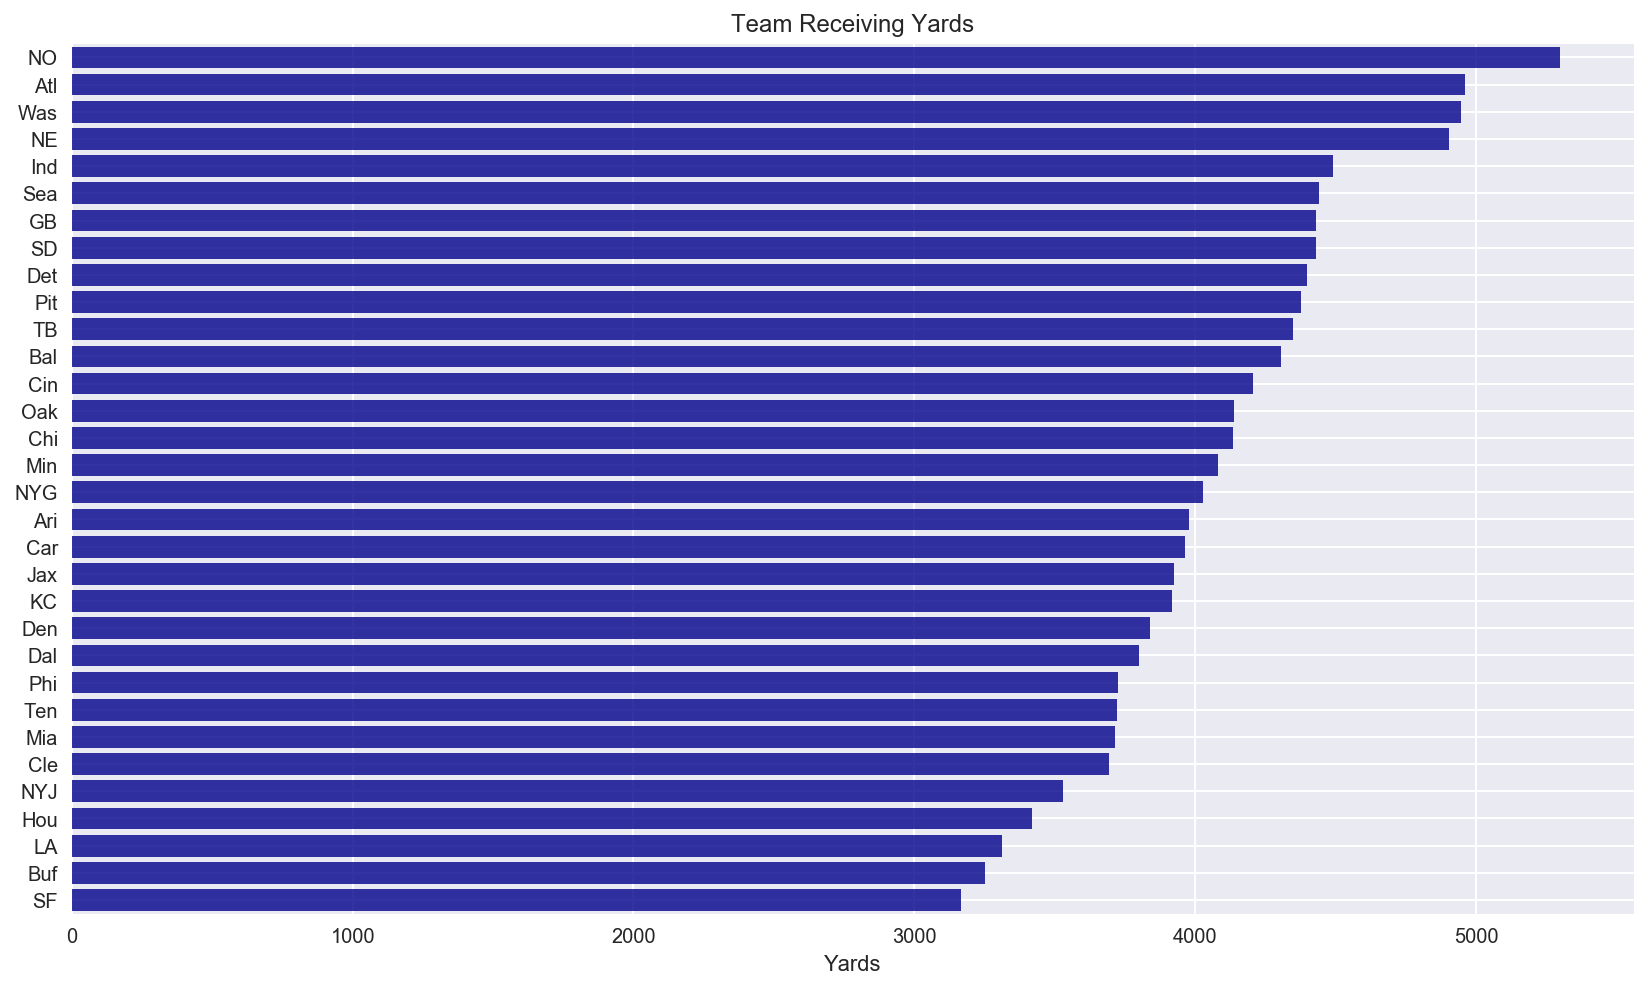

In [13]:
plt.subplots(figsize=(14,8))
plt.barh(bottom=team_yds.index, width=team_yds.yds, tick_label=team_yds.team, 
         align='center', color='darkblue', alpha=0.8)

plt.title('Team Receiving Yards')
plt.xlabel('Yards')
plt.ylim(-0.5,31.5)
plt.show()

In [14]:
# Setting up design Matrix
X = nfl_wr.loc[:, nfl_wr.dtypes != object]
X.head()

,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac
0,16,107,1023,9.56,63.9,32,6,59,150,358
1,15,106,1284,12.11,85.6,51,12,64,154,437
2,16,101,1367,13.53,85.4,75,10,65,169,534
3,16,98,1106,11.29,69.1,77,3,55,159,494
4,16,97,1257,12.96,78.6,60,14,62,152,361


In [15]:
# Normalizing Data
X = preprocessing.scale(X)

**K-Means Clustering**

In [17]:
# Range of K_values
k_lst = range(2,11)

silhouette = [] # Silhouette Scores
inertial = [] # Inertia

for k in k_lst:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    sil = metrics.silhouette_score(X, cluster_labels)
    silhouette.append(sil)
    inertial.append(kmeans.inertia_)

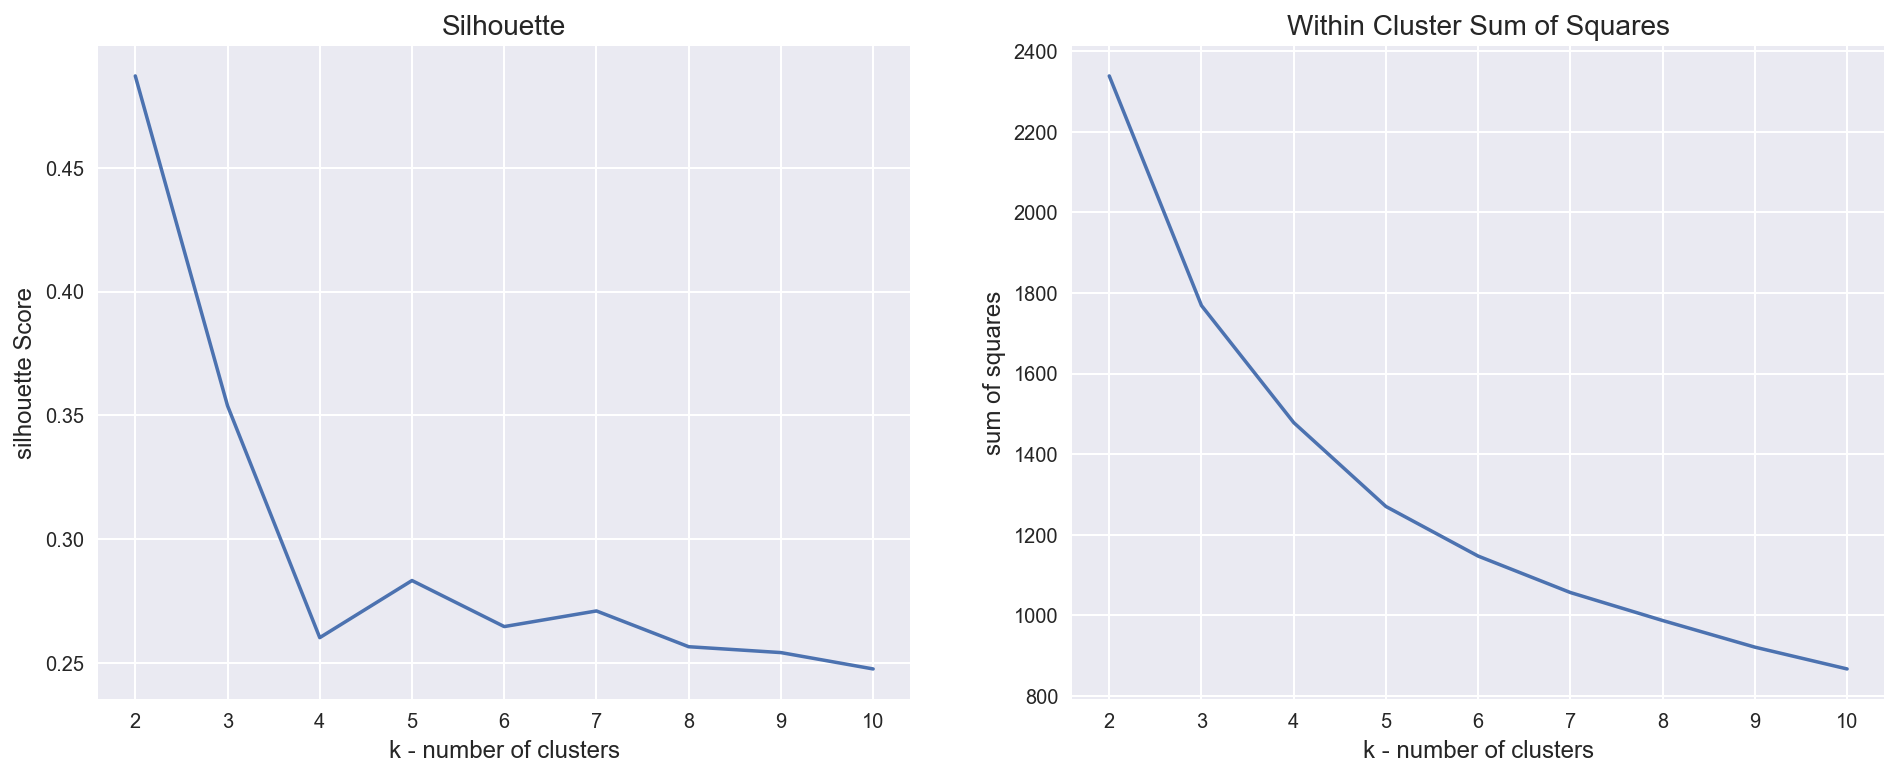

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].plot(k_lst, silhouette)
ax[0].set_xlabel('k - number of clusters', fontsize=12)
ax[0].set_ylabel('silhouette Score', fontsize=12)
ax[0].set_title('Silhouette', fontsize=14)

ax[1].plot(k_lst, inertial)
ax[1].set_xlabel('k - number of clusters', fontsize=12)
ax[1].set_ylabel('sum of squares', fontsize=12)
ax[1].set_title('Within Cluster Sum of Squares', fontsize=14)

plt.show()

Per the silhouette score graph there is a local maximum at k=5. Also we see the within cluster distance decrease rapidly from 2 to 5 clusters and then slowly decrease from 5 onward. Analyzing the sum of squares graph this way is the **Elbow Method** hueristic for determining the optimum k.

In [19]:
k = 5
kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(X)
cluster_labels = kmeans.labels_

In [20]:
cluster_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 4, 1, 4, 4, 1, 4, 1, 4, 1, 3, 1, 4, 4,
       3, 3, 3, 4, 4, 1, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 3,
       3, 4, 4, 4, 4, 0, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 0, 0, 0, 4, 4, 3,
       3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       4, 3, 4, 4, 3, 3, 3, 3, 4, 4, 0, 3, 3, 3, 3, 0, 3, 4, 4, 4, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 0, 3, 4, 4, 4, 4, 4, 0, 3, 3, 3, 0,
       0, 3,

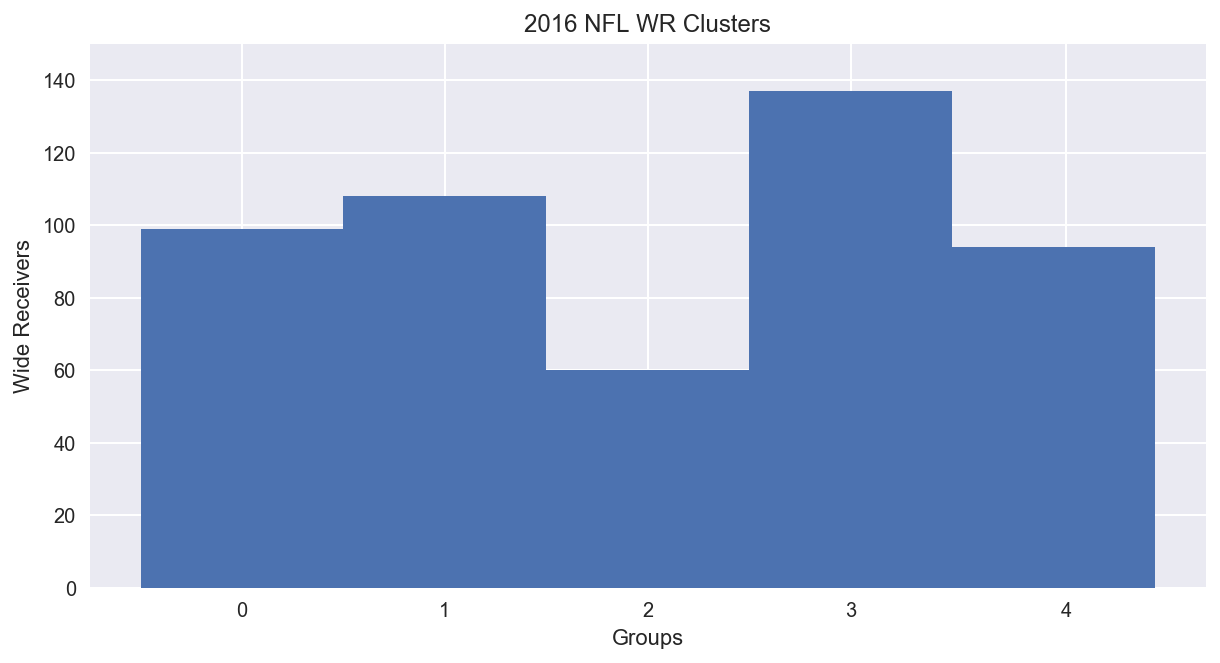

In [21]:
plt.subplots(figsize=(10,5))
plt.hist(cluster_labels, bins=5)
xticks_pos = [0.4, 1.2, 2, 2.8, 3.65]
labels=[0, 1, 2, 3, 4]
plt.ylim(0,150)
plt.xticks(xticks_pos, labels)
plt.xlabel('Groups')
plt.ylabel('Wide Receivers')
plt.title('2016 NFL WR Clusters')
plt.show()

In [22]:
nfl_wr['cluster_km'] = cluster_labels
cluster_summary = nfl_wr.groupby(by='cluster_km').mean().astype(int)
cluster_summary

,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac
cluster_km,,,,,,,,,,
0,4,2,21,5,5,8,0,1,4,14
1,14,40,443,11,31,43,2,21,63,219
2,15,74,957,12,62,56,5,46,117,341
3,13,9,71,7,5,14,0,3,13,50
4,10,10,144,15,16,36,0,6,18,58


**Group 0:** Bottom Bunch receiving production. Composed of Running Backs, blocking tight ends, and back up wide receivers

**Group 2:** Elite Wide Receivers. Average Yards = 957

In [23]:
cluster = 2
nfl_wr[nfl_wr.cluster_km == cluster].head(10)

,player,team,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac,cluster_km
0,Larry Fitzgerald,Ari,16,107,1023,9.56,63.9,32,6,59,150,358,2
1,Antonio Brown,Pit,15,106,1284,12.11,85.6,51,12,64,154,437,2
2,Odell Beckham Jr.,NYG,16,101,1367,13.53,85.4,75,10,65,169,534,2
3,Julian Edelman,NE,16,98,1106,11.29,69.1,77,3,55,159,494,2
4,Jordy Nelson,GB,16,97,1257,12.96,78.6,60,14,62,152,361,2
5,Mike Evans,TB,16,96,1321,13.76,82.6,45,12,80,173,179,2
6,Doug Baldwin,Sea,16,94,1128,12.00,70.5,59,7,51,125,472,2
7,Jarvis Landry,Mia,16,94,1136,12.09,71.0,71,4,52,131,616,2
8,Michael Thomas,NO,15,92,1137,12.36,75.8,46,9,62,121,483,2
9,Golden Tate,Det,16,91,1077,11.84,67.3,67,4,46,135,619,2


Having 5 clusters in this context makes sense becuase the set up of NFL offenses. 5 down linemen + 1 QB out of 11 offensive players on the field leaves 5 potential receiving targets. This group is composed of pure wide receivers, running backs, and tight ends. This model is position blind and only looks at receiving production as a whole regardless of whether a player is primarily a blocking tight end or a running back versus a receiver.

Further extension involves summarizing different groups, including costs/contracts, and seperating TE, RB, and WRs

**Hierarchical Clustering**

In [25]:
# Implementing the algorithm using Ward method (Minimizing the variance when forming clusters)
Z = linkage(X, method='ward', metric='euclidean')
Z

array([[ 479.        ,  488.        ,    0.        ,    2.        ],
       [ 493.        ,  498.        ,    0.        ,    3.        ],
       [ 474.        ,  487.        ,    0.        ,    2.        ],
       ..., 
       [ 984.        ,  990.        ,   23.475996  ,  193.        ],
       [ 991.        ,  992.        ,   40.47777517,  426.        ],
       [ 989.        ,  993.        ,   67.85172868,  498.        ]])

In [26]:
# Cophenetic Correlation Coefficient
c, coph_dists = cophenet(Z, pdist(X))

# C shows the goodness of fit for the clustering
c

0.74976138227425804

In [27]:
# sns.set_style("darkgrid")

def plot_dist_threash(max_dist=200):
    # max_dist = 200 # pairwise distance
    # plot_dendogram(lang)
    clusters = fcluster(Z, max_dist, criterion='distance')
    
    # Complete color maps from matplotlib
    cmaps = {'Perceptually Uniform Sequential':
                               ['viridis', 'inferno', 'plasma', 'magma'],
             'Sequential':     ['Blues', 'BuGn', 'BuPu',
                                 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                                 'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                                 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd'],
             'Sequential (2)': ['afmhot', 'autumn', 'bone', 'cool',
                                 'copper', 'gist_heat', 'gray', 'hot',
                                 'pink', 'spring', 'summer', 'winter'],
             'Diverging':      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                                 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                                 'seismic'],
             'Qualitative':    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                                 'Pastel2', 'Set1', 'Set2', 'Set3'],
             'Miscellaneous':  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                                 'brg', 'CMRmap', 'cubehelix',
                                 'gnuplot', 'gnuplot2', 'gist_ncar',
                                 'nipy_spectral', 'jet', 'rainbow',
                                 'gist_rainbow', 'hsv', 'flag', 'prism']
    }
    
    # plotting
    # Add legend with some customizations.
    
    plt.figure(1, figsize=(16, 4))
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X[:,0], X[:,6], c=clusters, cmap='prism', s=40)

    plt.title("Max Dist: %d" % max_dist)
    
    # plt.legend(clusters, loc='upper right', shadow=True, scatterpoints=1)
    
    plt.legend(['c{}'.format(i) for i in range(len(clusters))], 
               loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=11)
    
    plt.subplot(1, 2, 2)
    
    t = (0, max_dist)
    plt.plot((0, 200), (max_dist, max_dist), 'r--')
    
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')

    dendrogram(
        Z,
        truncate_mode='lastp',  
        p=15,  
        show_leaf_counts=False,  
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True
    )

    plt.show()

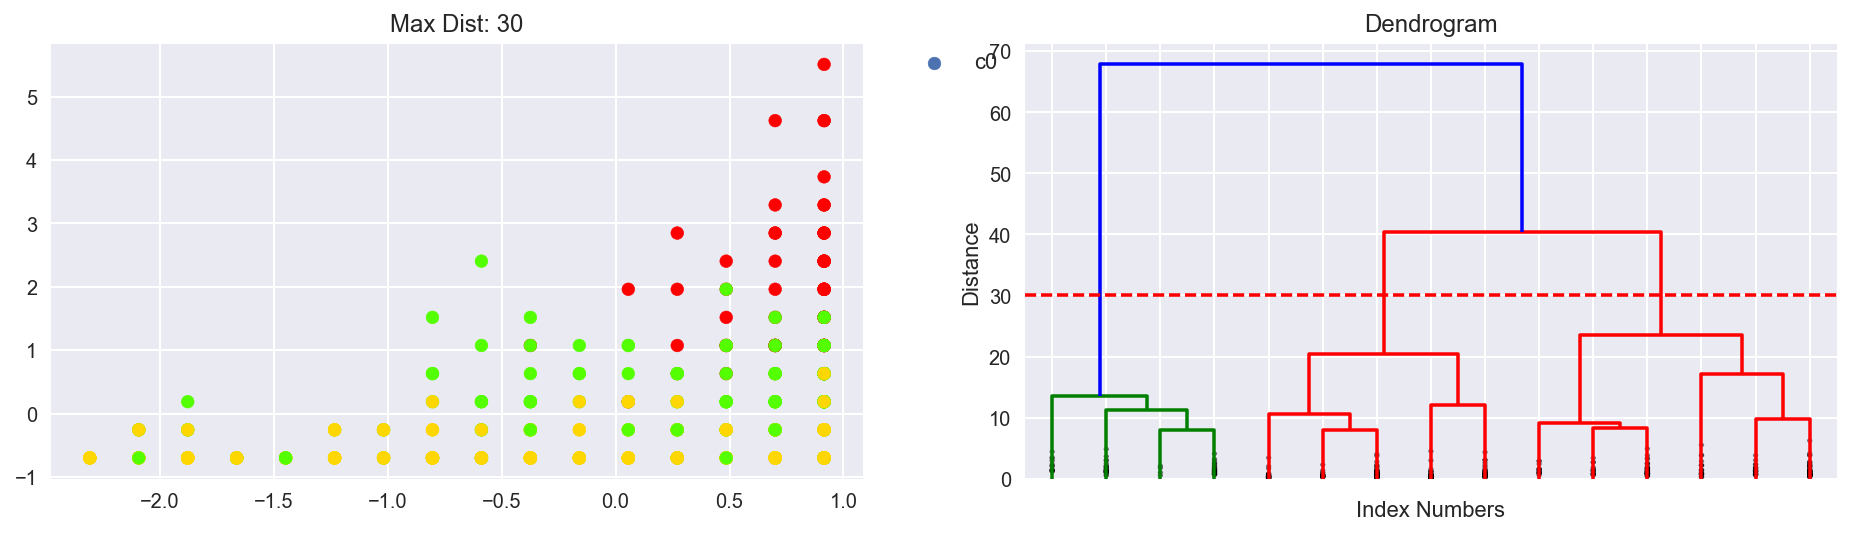

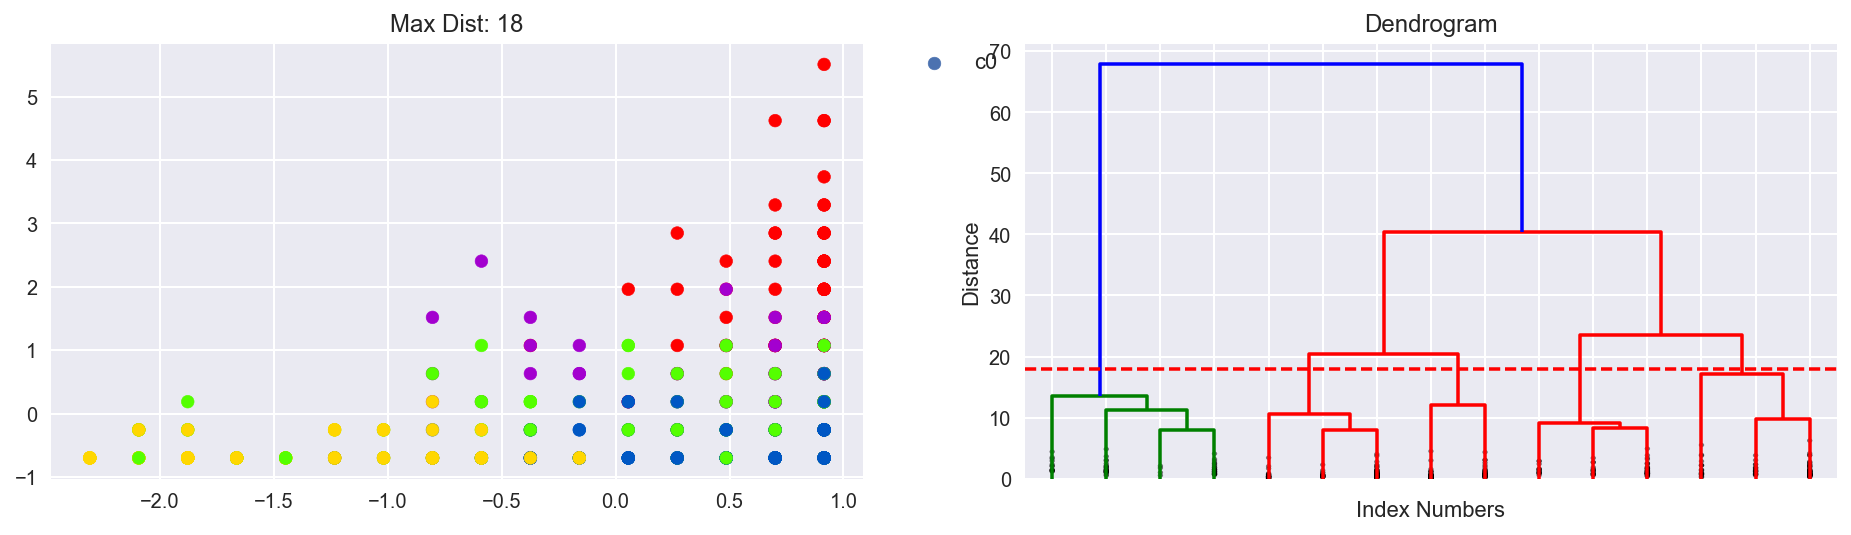

In [28]:
plot_dist_threash(30)
plot_dist_threash(18)

In [29]:
fcluster(Z, 18, criterion='distance') - 1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 3,
       0, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 0, 4, 3, 3, 4, 3, 3, 3, 0, 4, 3, 3, 0, 4, 0, 4, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 3,
       3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 2, 2, 2, 4, 4, 1,
       1, 1, 4, 4, 2, 4, 4, 1, 1, 4, 2, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 4,
       2, 4, 4, 4, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 2, 1, 4, 4, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 4, 4, 4, 4, 4, 2, 1, 1, 1, 2,
       2, 1,

In [30]:
nfl_wr['cluster_hc'] = (fcluster(Z, 18, criterion='distance') - 1)
nfl_wr.head()

,player,team,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac,cluster_km,cluster_hc
0,Larry Fitzgerald,Ari,16,107,1023,9.56,63.9,32,6,59,150,358,2,0
1,Antonio Brown,Pit,15,106,1284,12.11,85.6,51,12,64,154,437,2,0
2,Odell Beckham Jr.,NYG,16,101,1367,13.53,85.4,75,10,65,169,534,2,0
3,Julian Edelman,NE,16,98,1106,11.29,69.1,77,3,55,159,494,2,0
4,Jordy Nelson,GB,16,97,1257,12.96,78.6,60,14,62,152,361,2,0


In [31]:
# Inspecting the cluster groups

print 'K-Means Clusters:'

cols = filter(lambda x: x != 'cluster_hc', nfl_wr.columns)
print nfl_wr[cols].groupby(by='cluster_km').mean().astype(int)
print
print '\nHierarchical Clusters:'
cols = filter(lambda x: x != 'cluster_km', nfl_wr.columns)
print nfl_wr[cols].groupby(by='cluster_hc').mean().astype(int)

K-Means Clusters:
            gms  rec  yds  avg  ypg  lg  td  fd  tar  yac
cluster_km                                               
0             4    2   21    5    5   8   0   1    4   14
1            14   40  443   11   31  43   2  21   63  219
2            15   74  957   12   62  56   5  46  117  341
3            13    9   71    7    5  14   0   3   13   50
4            10   10  144   15   16  36   0   6   18   58


Hierarchical Clusters:
            gms  rec  yds  avg  ypg  lg  td  fd  tar  yac
cluster_hc                                               
0            15   70  900   13   59  58   5  43  110  328
1            13    6   51    7    4  13   0   2   10   31
2             4    3   27    6    6   9   0   1    5   16
3            14   42  457   11   32  42   2  22   66  218
4            11   17  182   13   17  35   1   8   26  100


**K-Means Clusters**
* Top Level: Group 2
* Bottom Level: Group 0

**Hierarchical Clusters**
* Top Level: Group 0
* Bottom Level: Group 2

---------

In [32]:
contract_data = pd.read_csv("2017_NFL_Contracts.csv").iloc[:, 1:]
contract_data.columns = map(lambda x: x.strip().lower(), contract_data.columns)
contract_data.head()

,player,pos,team,age,yrs,dollars,average,guaranteed at signing,practical guarantees,% gteed,free agent
0,Andrew Luck,QB,IND,27,5,"$122,970,000","$24,594,000","$44,000,000","$87,000,000",70.75%,2022
1,Aaron Rodgers,QB,GB,33,5,"$110,000,000","$22,000,000","$33,250,000","$54,000,000",49.09%,2020
2,Cam Newton,QB,CAR,27,5,"$103,800,000","$20,760,000","$41,000,000","$60,000,000",57.80%,2021
3,Matt Ryan,QB,ATL,31,5,"$103,750,000","$20,750,000","$30,000,000","$42,000,000",40.48%,2019
4,Tyron Smith,LT,DAL,26,8,"$97,600,000","$12,200,000","$22,118,013","$22,118,013",22.66%,2024


In [33]:
contract_data.pos.unique()

array(['QB', 'LT', 'WR', 'G', 'C', 'RT', 'TE', 'RB', 'FB'], dtype=object)

In [34]:
mask = (contract_data.pos == 'WR') | (contract_data.pos == 'TE') |\
       (contract_data.pos == 'RB') | (contract_data.pos == 'FB')
    
receiving_contract = contract_data[mask]

receiving_contract.player = receiving_contract.player.apply(lambda x: x.strip().replace(',', '')) 

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [35]:
receiving_contract.head()

,player,pos,team,age,yrs,dollars,average,guaranteed at signing,practical guarantees,% gteed,free agent
13,Julio Jones,WR,ATL,28,5,"$71,256,045","$14,251,209","$35,500,000","$47,000,000",65.96%,2021
14,Dez Bryant,WR,DAL,28,5,"$70,000,000","$14,000,000","$32,000,000","$45,000,000",64.29%,2020
15,Demaryius Thomas,WR,DEN,29,5,"$70,000,000","$14,000,000","$35,000,000","$43,500,000",62.14%,2020
17,Antonio Brown,WR,PIT,28,4,"$68,000,000","$17,000,000","$19,000,000","$19,000,000",27.94%,2022
20,T.Y. Hilton,WR,IND,27,5,"$65,000,000","$13,000,000","$11,000,000","$28,000,000",43.08%,2021


In [36]:
nfl_wr.head()

,player,team,gms,rec,yds,avg,ypg,lg,td,fd,tar,yac,cluster_km,cluster_hc
0,Larry Fitzgerald,Ari,16,107,1023,9.56,63.9,32,6,59,150,358,2,0
1,Antonio Brown,Pit,15,106,1284,12.11,85.6,51,12,64,154,437,2,0
2,Odell Beckham Jr.,NYG,16,101,1367,13.53,85.4,75,10,65,169,534,2,0
3,Julian Edelman,NE,16,98,1106,11.29,69.1,77,3,55,159,494,2,0
4,Jordy Nelson,GB,16,97,1257,12.96,78.6,60,14,62,152,361,2,0


In [37]:
# REPLACING NAMES
name_corrections = {'Philly Brown' : 'Corey Brown', 'Henry Krieger Coble' : 'Henry Krieger-Coble',
                    'Khalif Raymond' : 'Kalif Raymond', 'Matt Slater' : 'Matthew Slater',
                    'Fitzgerald Toussaint' : 'Fitz Toussaint', 'Wendall Williams' : 'Wendell Williams'}

nfl_wr.player.replace(name_corrections, inplace=True)

# REMOVE RETIRED PLAYERS, QBS, & LINEMEN FROM DATAFRAME
retired = ['Andre Johnson', 'Arian Foster', 'Steve Smith', 'Isaiah Pead', 'Pat McAfee', 'Cecil Shorts']

qbs = ['Russell Wilson', 'Blaine Gabbert', 'Brock Osweiler', 'Matt Barkley', 'Jimmy Garoppolo', 
       'Alex Smith', 'Joe Webb', 'Sam Bradford', 'Carson Wentz', 'Blake Bortles', 'Marcus Mariota']

linemen = ['Donald Penn', 'Taylor Lewan', 'Jake Fisher', 'Eric Fisher', 'Alex Lewis']

for player in (retired + qbs + linemen):
    nfl_wr = nfl_wr[nfl_wr.player != player]

In [38]:
cols = filter(lambda x: x not in ['guaranteed at signing', '% gteed'], receiving_contract.columns)
data = pd.merge(left=nfl_wr, right=receiving_contract[cols], how='left', on='player')
data.head()

,player,team_x,gms,rec,yds,avg,ypg,lg,td,fd,...,cluster_km,cluster_hc,pos,team_y,age,yrs,dollars,average,practical guarantees,free agent
0,Larry Fitzgerald,Ari,16,107,1023,9.56,63.9,32,6,59,...,2,0,WR,ARI,33.0,1.0,"$11,000,000","$11,000,000","$11,000,000",2018.0
1,Antonio Brown,Pit,15,106,1284,12.11,85.6,51,12,64,...,2,0,WR,PIT,28.0,4.0,"$68,000,000","$17,000,000","$19,000,000",2022.0
2,Odell Beckham Jr.,NYG,16,101,1367,13.53,85.4,75,10,65,...,2,0,WR,NYG,24.0,4.0,"$10,406,198","$2,601,550","$10,406,198",2019.0
3,Julian Edelman,NE,16,98,1106,11.29,69.1,77,3,55,...,2,0,WR,NE,30.0,4.0,"$17,000,000","$4,250,000","$8,000,000",2018.0
4,Jordy Nelson,GB,16,97,1257,12.96,78.6,60,14,62,...,2,0,WR,GB,31.0,4.0,"$39,050,000","$9,762,500","$11,500,000",2019.0


In [39]:
# PLAYERS WITH NAN VALUES AS RESULT OF MERGE
# DID NOT HAVE CONTRACTS FOR UPCOMING 2017 SEASON
data.dropna(inplace=True)

In [40]:
data.dtypes

player                   object
team_x                   object
gms                       int64
rec                       int64
yds                       int64
avg                     float64
ypg                     float64
lg                        int64
td                        int64
fd                        int64
tar                       int64
yac                       int64
cluster_km                int32
cluster_hc                int32
pos                      object
team_y                   object
age                     float64
yrs                     float64
dollars                  object
average                  object
practical guarantees     object
free agent              float64
dtype: object

In [41]:
# FORMATTING DATA
data['age'] = data['age'].astype(int)
data['yrs'] = data['yrs'].astype(int)
data['free agent'] = data['free agent'].astype(int)

for col in ['dollars', 'average', 'practical guarantees']:
    data[col] =\
    data[col].apply(lambda x: x.strip().replace('$','').replace(',','').replace('-', '0')).astype(int)
    
# RENAME COLUMN    
data.rename(index=str, columns={'team_x': 'team_2016', 'team_y': 'team_2017'}, inplace=True)

data.team_2016 = data.team_2016.apply(lambda x: x.upper())

# REARRANGE COLUMNS
cols = filter(lambda x: (x != 'cluster_km') & (x != 'cluster_hc'), data.columns) + ['cluster_km', 'cluster_hc']
data = data[cols]

data.reset_index(drop=True, inplace=True)

In [42]:
data.head()

,player,team_2016,gms,rec,yds,avg,ypg,lg,td,fd,...,pos,team_2017,age,yrs,dollars,average,practical guarantees,free agent,cluster_km,cluster_hc
0,Larry Fitzgerald,ARI,16,107,1023,9.56,63.9,32,6,59,...,WR,ARI,33,1,11000000,11000000,11000000,2018,2,0
1,Antonio Brown,PIT,15,106,1284,12.11,85.6,51,12,64,...,WR,PIT,28,4,68000000,17000000,19000000,2022,2,0
2,Odell Beckham Jr.,NYG,16,101,1367,13.53,85.4,75,10,65,...,WR,NYG,24,4,10406198,2601550,10406198,2019,2,0
3,Julian Edelman,NE,16,98,1106,11.29,69.1,77,3,55,...,WR,NE,30,4,17000000,4250000,8000000,2018,2,0
4,Jordy Nelson,GB,16,97,1257,12.96,78.6,60,14,62,...,WR,GB,31,4,39050000,9762500,11500000,2019,2,0


_Two David Johnsons in DataFrame resulted in 4 total combinations during the merge._

In [43]:
data[data.player == "David Johnson"]

,player,team_2016,gms,rec,yds,avg,ypg,lg,td,fd,...,pos,team_2017,age,yrs,dollars,average,practical guarantees,free agent,cluster_km,cluster_hc
19,David Johnson,ARI,16,80,879,10.99,54.9,58,4,42,...,RB,ARI,25,4,2919373,729843,639373,2019,2,0
20,David Johnson,ARI,16,80,879,10.99,54.9,58,4,42,...,TE,PIT,29,2,2050000,1025000,235000,2019,2,0
287,David Johnson,PIT,16,7,80,11.43,5.0,26,0,5,...,RB,ARI,25,4,2919373,729843,639373,2019,3,1
288,David Johnson,PIT,16,7,80,11.43,5.0,26,0,5,...,TE,PIT,29,2,2050000,1025000,235000,2019,3,1


In [44]:
data = data.drop([20, 288])
data.reset_index(drop=True, inplace=True)
data[data.player == "David Johnson"]

,player,team_2016,gms,rec,yds,avg,ypg,lg,td,fd,...,pos,team_2017,age,yrs,dollars,average,practical guarantees,free agent,cluster_km,cluster_hc
19,David Johnson,ARI,16,80,879,10.99,54.9,58,4,42,...,RB,ARI,25,4,2919373,729843,639373,2019,2,0
286,David Johnson,PIT,16,7,80,11.43,5.0,26,0,5,...,RB,ARI,25,4,2919373,729843,639373,2019,3,1


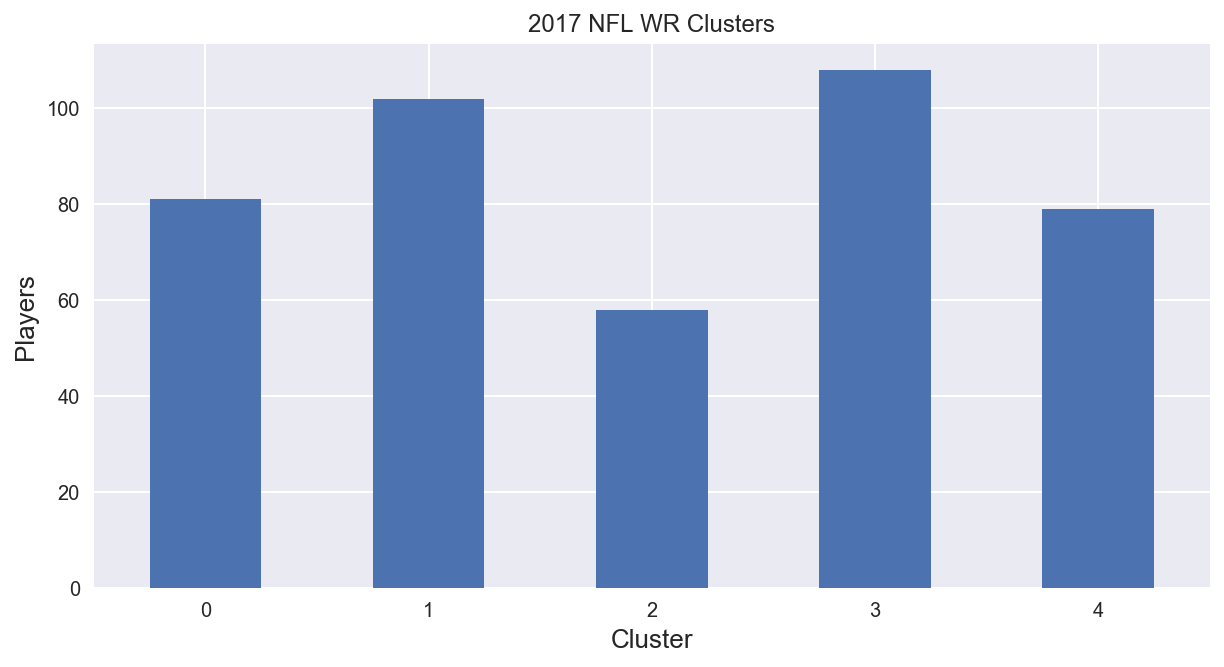

In [45]:
plt.subplots(figsize=(10,5))
data.groupby(by='cluster_km')['player'].count().plot(kind='bar', rot=0)
plt.title('2017 NFL WR Clusters')
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('Players', fontsize=13)
plt.show()

In [46]:
def cluster_summary(df, group, k_means_cluster = True):
    if k_means_cluster:
        cluster = 'cluster_km'
        message = 'K-Means Result'
    else:
        cluster = 'cluster_hc' 
        message = 'Hierarchical Result'
    
    print message
    print
    print 'Annual Average Salary: %s' %'${:,.0f}'.format(int(df.loc[df[cluster] == group, 'average'].mean()))
    print
    print 'Sample:'
    print df.loc[df[cluster] == group, ['player', 'team_2017', 'pos', 'age', 'average']].head()
    print
    print '\nGroup:\n'
    print reduce(lambda x,y: x + ', ' + y, 
          map(lambda x: x[0] +' '+ x[1] +' '+ x[2] +' Age['+ str(x[3]) +'] '+ '${:,.0f}'.format(x[4]), 
                                     zip(df.loc[df[cluster] == group, 'player'],  
                                         df.loc[df[cluster] == group, 'team_2017'],
                                         df.loc[df[cluster] == group, 'pos'],
                                         df.loc[df[cluster] == group, 'age'],
                                         df.loc[df[cluster] == group, 'average'])))
    return

In [47]:
cluster_summary(data, 2, True)

K-Means Result

Annual Average Salary: $6,146,651

Sample:
              player team_2017 pos  age   average
0   Larry Fitzgerald       ARI  WR   33  11000000
1      Antonio Brown       PIT  WR   28  17000000
2  Odell Beckham Jr.       NYG  WR   24   2601550
3     Julian Edelman        NE  WR   30   4250000
4       Jordy Nelson        GB  WR   31   9762500


Group:

Larry Fitzgerald ARI WR Age[33] $11,000,000, Antonio Brown PIT WR Age[28] $17,000,000, Odell Beckham Jr. NYG WR Age[24] $2,601,550, Julian Edelman NE WR Age[30] $4,250,000, Jordy Nelson GB WR Age[31] $9,762,500, Mike Evans TB WR Age[23] $3,657,876, Doug Baldwin SEA WR Age[28] $11,500,000, Jarvis Landry MIA WR Age[24] $868,728, Michael Thomas NO WR Age[24] $1,279,743, Golden Tate DET WR Age[28] $6,200,000, T.Y. Hilton IND WR Age[27] $13,000,000, Demaryius Thomas DEN WR Age[29] $14,000,000, Michael Crabtree OAK WR Age[29] $8,500,000, Dennis Pitta BAL TE Age[31] $6,400,000, Travis Kelce KC TE Age[27] $9,368,400, Stefon Diggs M

In [48]:
cluster_summary(data, 0, False)

Hierarchical Result

Annual Average Salary: $5,730,913

Sample:
              player team_2017 pos  age   average
0   Larry Fitzgerald       ARI  WR   33  11000000
1      Antonio Brown       PIT  WR   28  17000000
2  Odell Beckham Jr.       NYG  WR   24   2601550
3     Julian Edelman        NE  WR   30   4250000
4       Jordy Nelson        GB  WR   31   9762500


Group:

Larry Fitzgerald ARI WR Age[33] $11,000,000, Antonio Brown PIT WR Age[28] $17,000,000, Odell Beckham Jr. NYG WR Age[24] $2,601,550, Julian Edelman NE WR Age[30] $4,250,000, Jordy Nelson GB WR Age[31] $9,762,500, Mike Evans TB WR Age[23] $3,657,876, Doug Baldwin SEA WR Age[28] $11,500,000, Jarvis Landry MIA WR Age[24] $868,728, Michael Thomas NO WR Age[24] $1,279,743, Golden Tate DET WR Age[28] $6,200,000, T.Y. Hilton IND WR Age[27] $13,000,000, Demaryius Thomas DEN WR Age[29] $14,000,000, Michael Crabtree OAK WR Age[29] $8,500,000, Travis Kelce KC TE Age[27] $9,368,400, Stefon Diggs MIN WR Age[23] $626,928, Kyle Rudolp